In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset

In [80]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    plt.title('R2: {}'.format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend()
    plt.show()

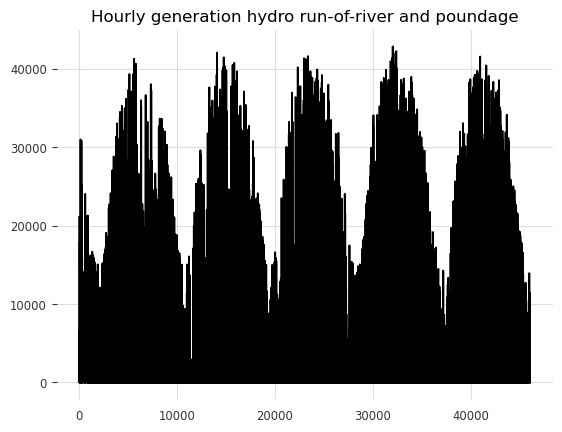

In [81]:
df = pd.read_csv('../train_clean.csv')
df['t'].plot()

plt.title('Hourly generation hydro run-of-river and poundage')
plt.show()

In [84]:
df_day_avg = df.groupby(df['Date'].astype(str).str.split(" ").str[0]).mean().reset_index()

In [85]:
df_day_avg

,Date,Unnamed: 0,year,month,day,hour,t-3,t-2,t-1,t
0,2011-09-30,7.0,2011.0,9.0,30.0,19.0,9015.617778,7651.085556,7255.098889,4410.903333
1,2011-10-01,23.5,2011.0,10.0,1.0,11.5,1112.744167,1112.744167,1112.744167,1112.744167
2,2011-10-02,47.5,2011.0,10.0,2.0,11.5,1238.127917,1238.127917,1238.127917,1238.127917
3,2011-10-03,71.5,2011.0,10.0,3.0,11.5,2728.471250,2728.471250,2728.471250,2728.471250
4,2011-10-04,95.5,2011.0,10.0,4.0,11.5,3307.366250,3307.366250,3307.366250,3307.366250
...,...,...,...,...,...,...,...,...,...,...
1914,2016-12-26,45935.5,2016.0,12.0,26.0,11.5,760.134167,760.134167,760.134167,760.134167
1915,2016-12-27,45959.5,2016.0,12.0,27.0,11.5,2023.522917,2023.522917,2023.522917,2023.522917
1916,2016-12-28,45983.5,2016.0,12.0,28.0,11.5,1295.153750,1295.153750,1295.153750,1295.153750
1917,2016-12-29,46007.5,2016.0,12.0,29.0,11.5,1415.116667,1415.116667,1415.116667,1415.116667


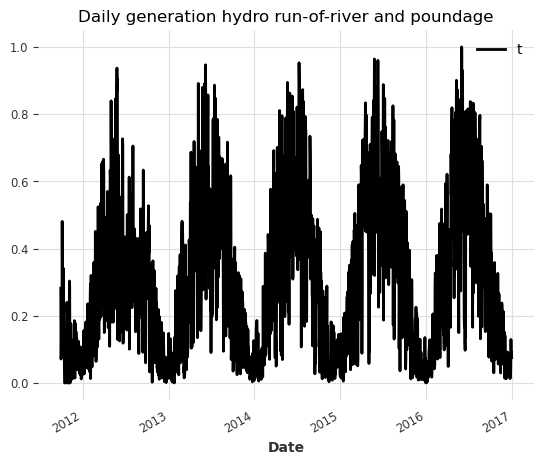

In [86]:
scaler = Scaler()
series = scaler.fit_transform(
        TimeSeries.from_dataframe(
            df_day_avg, 'Date', ['t'])
)
series.plot()
plt.title('Daily generation hydro run-of-river and poundage')
plt.show()

In [87]:
train, val = series.split_after(pd.Timestamp('2015-12-31'))

In [88]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=2,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=1000,
    model_name='nbeats_run',
    force_reset=True
)

In [89]:
model_nbeats.fit(train, val_series=val, verbose=True)

[2021-08-23 12:41:15,849] INFO | darts.models.torch_forecasting_model | Train dataset contains 1518 samples.
[2021-08-23 12:41:15,849] INFO | darts.models.torch_forecasting_model | Train dataset contains 1518 samples.
[2021-08-23 12:41:15,956] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-23 12:41:15,956] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

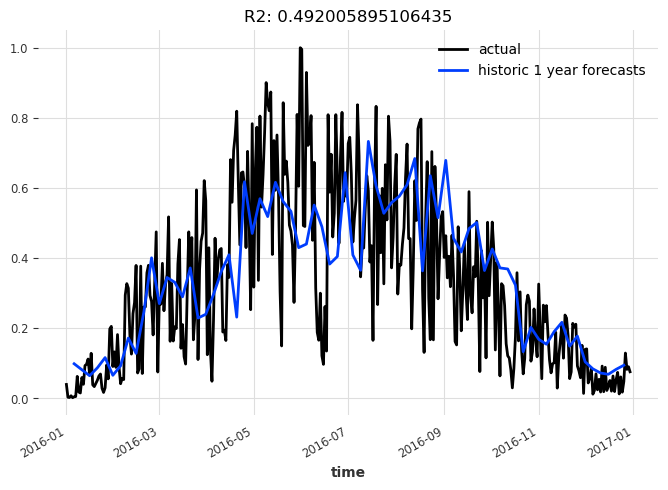

In [90]:
pred_series = model_nbeats.historical_forecasts(
    series,
    start=pd.Timestamp('2015-12-31'),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True
)
display_forecast(pred_series, 
                 series, 
                 '1 year', 
                 start_date=pd.Timestamp('2015-12-31'))